In [1]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
from classes.optimizers.md_simulator1 import MDTP_simulator
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

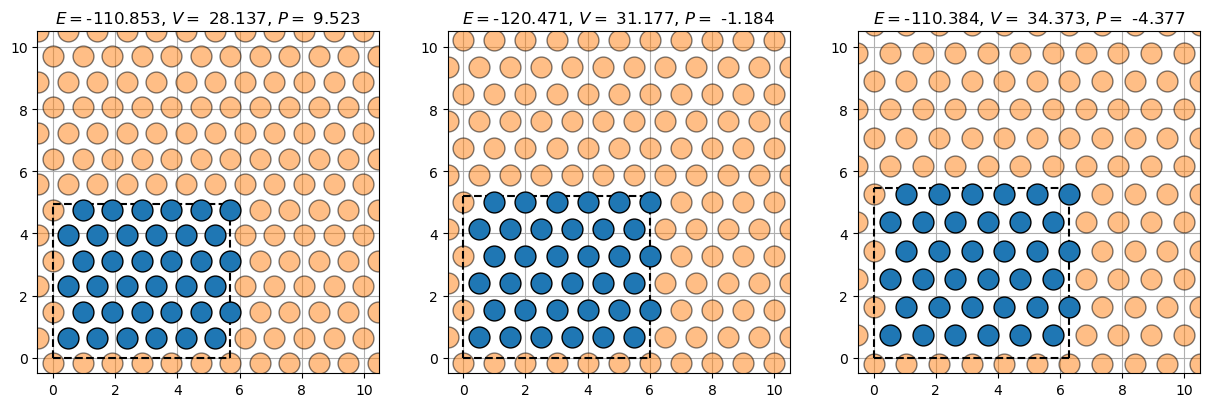

In [2]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler) #Would like to fix this sometime
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0]:
    for j in [0.0, 1.0, 2.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([6.0, 0.0]), 3*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(6**2, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

In [11]:
temps = [0.40, 0.45, 0.50, 0.55, 0.60, 0.60, 0.55, 0.50, 0.45, 0.40]
atom_col = copy.deepcopy(scaled_cols[1])
md_simulator = MDTP_simulator(atom_col=atom_col,temp=0.15)
total_logged_cols = []
for temp in temps:
    md_simulator.temp = temp
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2)
    total_logged_cols.append(md_simulator.logged_atom_cols)
    md_simulator.logged_atom_cols = []

In [12]:
volumes_mean = []
pressures_mean = []
energies_mean = []
for temp, atom_cols in zip(temps, total_logged_cols):
    volumes = []
    energies = []
    pressures = []
    for atom_coll in atom_cols:
        volumes.append(atom_coll.get_volume())
        pressures.append(atom_coll.get_pressure())
        energies.append(atom_coll.get_potential_energy())
    pressures_mean.append(np.mean(pressures[:-int(300/2)]))
    volumes_mean.append(np.mean(volumes[:-int(300/2)]))
    energies_mean.append(np.mean(energies[:-int(300/2)]))

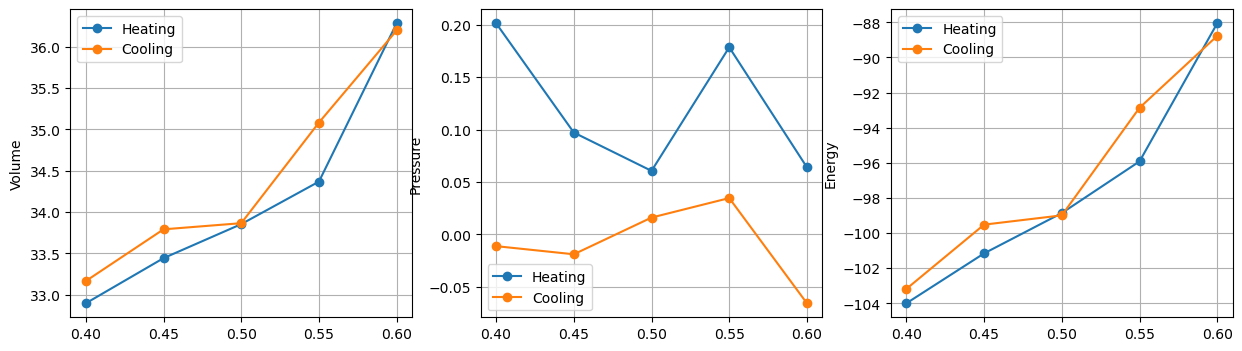

In [20]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(temps[0:5], volumes_mean[0:5],"o-", c="C0", label="Heating")
axs[0].set_ylabel("Volume")
axs[1].plot(temps[0:5], pressures_mean[0:5], "o-", c="C0", label="Heating")
axs[1].set_ylabel("Pressure")
axs[2].plot(temps[0:5], energies_mean[0:5], "o-", c="C0", label="Heating")
axs[2].set_ylabel("Energy")
axs[0].plot(temps[5:], volumes_mean[5:], "o-", c="C1", label="Cooling")
axs[1].plot(temps[5:], pressures_mean[5:], "o-", c="C1", label="Cooling")
axs[2].plot(temps[5:], energies_mean[5:], "o-", c="C1", label="Cooling")
for ax in axs:
    ax.legend()
    ax.grid()

In [21]:
temps = [0.0, 0.05, 0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 1.0, 1.2, 1.2, 1.0, 0.80, 0.70, 0.60, 0.40, 0.30, 0.10, 0.05, 0.0]
atom_col = copy.deepcopy(scaled_cols[1])
md_simulator = MDTP_simulator(atom_col=atom_col,temp=0.15)
total_logged_cols = []
for temp in temps:
    md_simulator.temp = temp
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2)
    total_logged_cols.append(md_simulator.logged_atom_cols)
    md_simulator.logged_atom_cols = []

In [22]:
volumes_mean = []
#pressures_mean = []
#energies_mean = []
for temp, atom_cols in zip(temps, total_logged_cols):
    volumes = []
    #energies = []
    #pressures = []
    for atom_coll in atom_cols:
        volumes.append(atom_coll.get_volume())
        #pressures.append(atom_coll.get_pressure())
        #energies.append(atom_coll.get_potential_energy())
    #pressures_mean.append(np.mean(pressures[:-int(300/2)]))
    volumes_mean.append(np.mean(volumes[:-int(300/2)]))
    #energies_mean.append(np.mean(energies[:-int(300/2)]))

In [23]:
print(volumes_mean)

[30.614875595595333, 30.82074638444796, 31.05376303758308, 31.559719757637076, 32.238600769269325, 32.87744164841282, 35.782310967695494, 40.0637994011543, 44.22662870447258, 48.28462099652556, 52.67818642581399, 63.856749118725475, 60.51341913071788, 55.57475414251018, 46.90919969163453, 41.562957287186144, 38.456284120026396, 34.943655580449935, 32.83757807476657, 33.05769302957156, 32.795885087247015]


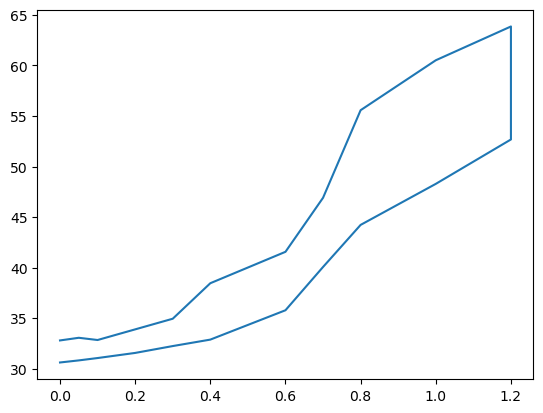

In [25]:
fig, ax = plt.subplots()
ax.plot(temps, volumes_mean)

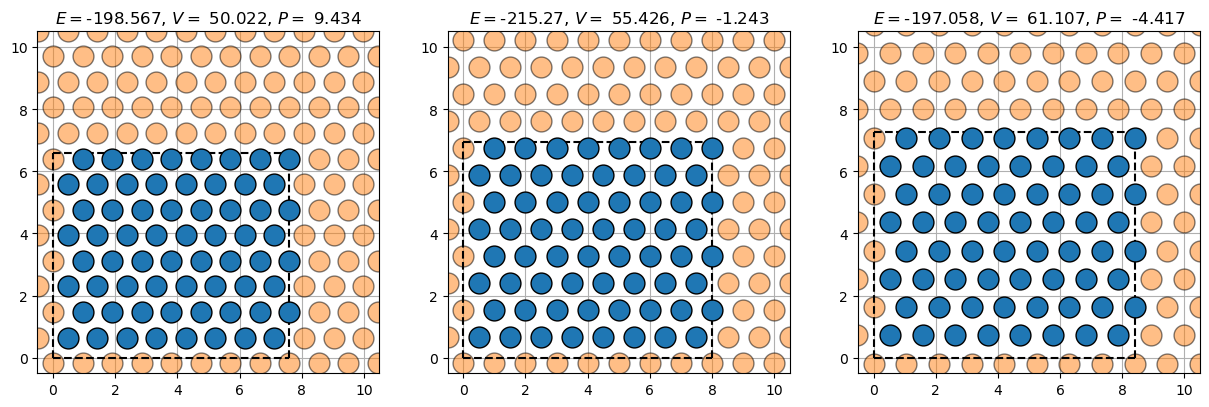

In [42]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

unit_cell = (np.array([2.0, 0.0]), np.cos(np.pi/6.0)*np.array([0.0,2.0]))
atom_poses = [np.array([0.0,0.0]), np.array([0.5,0.5]), np.array([1.0,0.0]), np.array([1.5,0.5])]
atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=30) for pos in atom_poses], unit_cell=unit_cell, pbc=True)
atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler) #Would like to fix this sometime
optimizer = Line_searcher(atom_col=atom_col)
pos_opt, f = optimizer.run(fmax=0.05)
opt_col = create_atom_col_copies(atom_col=atom_col, positions=pos_opt, velocities=np.zeros(shape=pos_opt.shape))[0]
l1, l2 = unit_cell
new_poses = []
for i in [0.0, 1.0, 2.0, 3.0]:
    for j in [0.0, 1.0, 2.0, 3.0]:
        disp_pos = pos_opt + l1*i + l2*j
        new_poses.append(disp_pos)

unit_cell = (np.array([8.0, 0.0]), 4*np.cos(np.pi/6.0)*np.array([0.0,2.0]))
scaling_factors = [-0.05, 0.0, 0.05]
scaled_cols = []
for ax, scaling_factor in zip(axs, scaling_factors):
    ax.set_xlim([-0.5,10.5])
    ax.set_ylim([-0.5,10.5])
    ax.grid()
    ax.set_aspect("equal")
    atom_col = Atom_Collection(atomlist=[Atom(position=pos, size=20) for pos in np.array(new_poses).reshape(64, 2)], unit_cell=unit_cell, pbc=True)
    atom_col.calculator = LennardJones(eps0=1.0, pbc=atom_col.pbc, pbc_handler=atom_col.pbc_handler)
    atom_col.scale_volume(scale_x=scaling_factor, scale_y=scaling_factor)
    vol = atom_col.volume
    p = atom_col.get_pressure(step_size=1e-4)
    ax.set_title(rf"$E = ${atom_col.get_potential_energy().round(3)}, $V = $ {vol.round(3)}, $P = $ {p.round(3)}")
    atom_col.plot_cells(ax=ax, size=15)
    atom_col.reset_plot_axes()
    scaled_cols.append(atom_col)

In [43]:
temps = [0.10, 0.20, 0.30, 0.40, 0.60, 0.70, 0.80, 1.0, 1.2, 1.4, 1.6, 2.1, 2.8, 2.1, 1.6, 1.4,1.2,1.0, 0.80, 0.70, 0.60, 0.40, 0.30, 0.20, 0.10]
atom_col = copy.deepcopy(scaled_cols[1])
md_simulator = MDTP_simulator(atom_col=atom_col,temp=0.15)
total_logged_cols = []
for temp in temps:
    md_simulator.temp = temp
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2)
    total_logged_cols.append(md_simulator.logged_atom_cols)
    md_simulator.logged_atom_cols = []

In [44]:
volumes_mean = []
#pressures_mean = []
#energies_mean = []
for temp, atom_cols in zip(temps, total_logged_cols):
    volumes = []
    #energies = []
    #pressures = []
    for atom_coll in atom_cols:
        volumes.append(atom_coll.get_volume())
        #pressures.append(atom_coll.get_pressure())
        #energies.append(atom_coll.get_potential_energy())
    #pressures_mean.append(np.mean(pressures[:-int(300/2)]))
    volumes_mean.append(np.mean(volumes[:-int(300/2)]))
    #energies_mean.append(np.mean(energies[:-int(300/2)]))

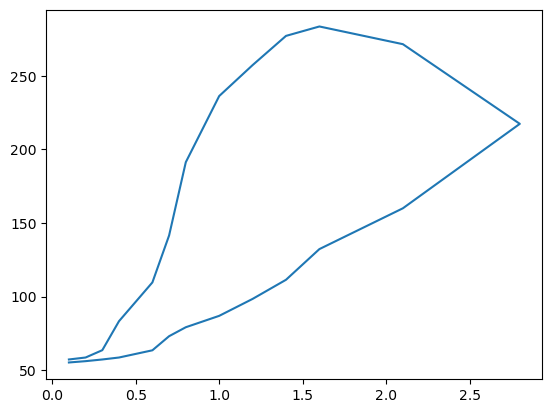

In [45]:
fig, ax = plt.subplots()
ax.plot(temps, volumes_mean)